# Lab 06: Credit Card Fraud Detection

---
author: Henry Guo
date: April 4, 2024
embed-resources: true
---

## Introduction

A bank issues credit cards to their customers. The following code automatically detecting fraudulent transactions. The model predicts whether or not each credit card transaction is fraud or not.
The data for this lab originally comes from Kaggle. Citations for the data can be found on [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/). 

## Methods

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV, train_test_split
from joblib import dump

### Data

In [2]:
fraud = pd.read_csv("https://cs307.org/lab-06/data/fraud.csv")
fraud_train, fraud_test = train_test_split(
    fraud,
    test_size=0.20,
    random_state=42,
    stratify=fraud["Fraud"],
)
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]
X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]

"Fraud" is the status of the transaction. 1 indicates a fraudulent transaction and 0 indicates not fraud, a genuine transaction.

"Amount" is the amount (in dollars) of the transaction.

"PC01 - PC28" are the 28 principal components that encode information such as location and type of purchase while preserving customer privacy.

In [3]:
count = fraud_train['Fraud'].value_counts()
count_prop = fraud_train['Fraud'].value_counts(normalize=True)
stats0 = fraud_train['Amount'].agg(['mean','std','median','max'])
stats = fraud_train.groupby('Fraud')['Amount'].agg(['mean','std','median','max'])
count, count_prop, stats0,stats

(Fraud
 0    53961
 1      315
 Name: count, dtype: int64,
 Fraud
 0    0.994196
 1    0.005804
 Name: proportion, dtype: float64,
 mean         88.197903
 std         241.535617
 median       21.690000
 max       10199.440000
 Name: Amount, dtype: float64,
              mean         std  median       max
 Fraud                                          
 0       88.065104  241.451144   21.80  10199.44
 1      110.947016  254.978960    6.99   2125.87)

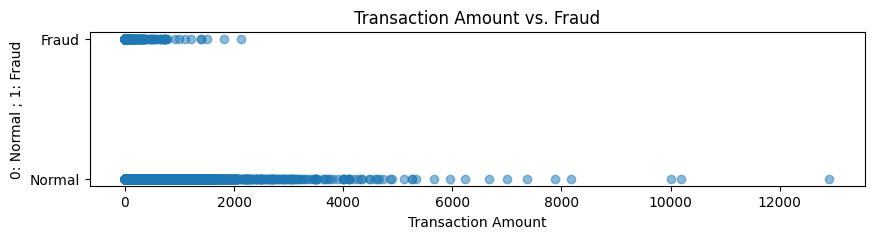

In [4]:
plt.figure(figsize=(10, 2))
plt.scatter(fraud['Amount'], fraud['Fraud'], alpha=0.5)
plt.xlabel('Transaction Amount')
plt.yticks([0,1],['Normal','Fraud'])
plt.ylabel('0: Normal ; 1: Fraud')
plt.title('Transaction Amount vs. Fraud')
plt.show()

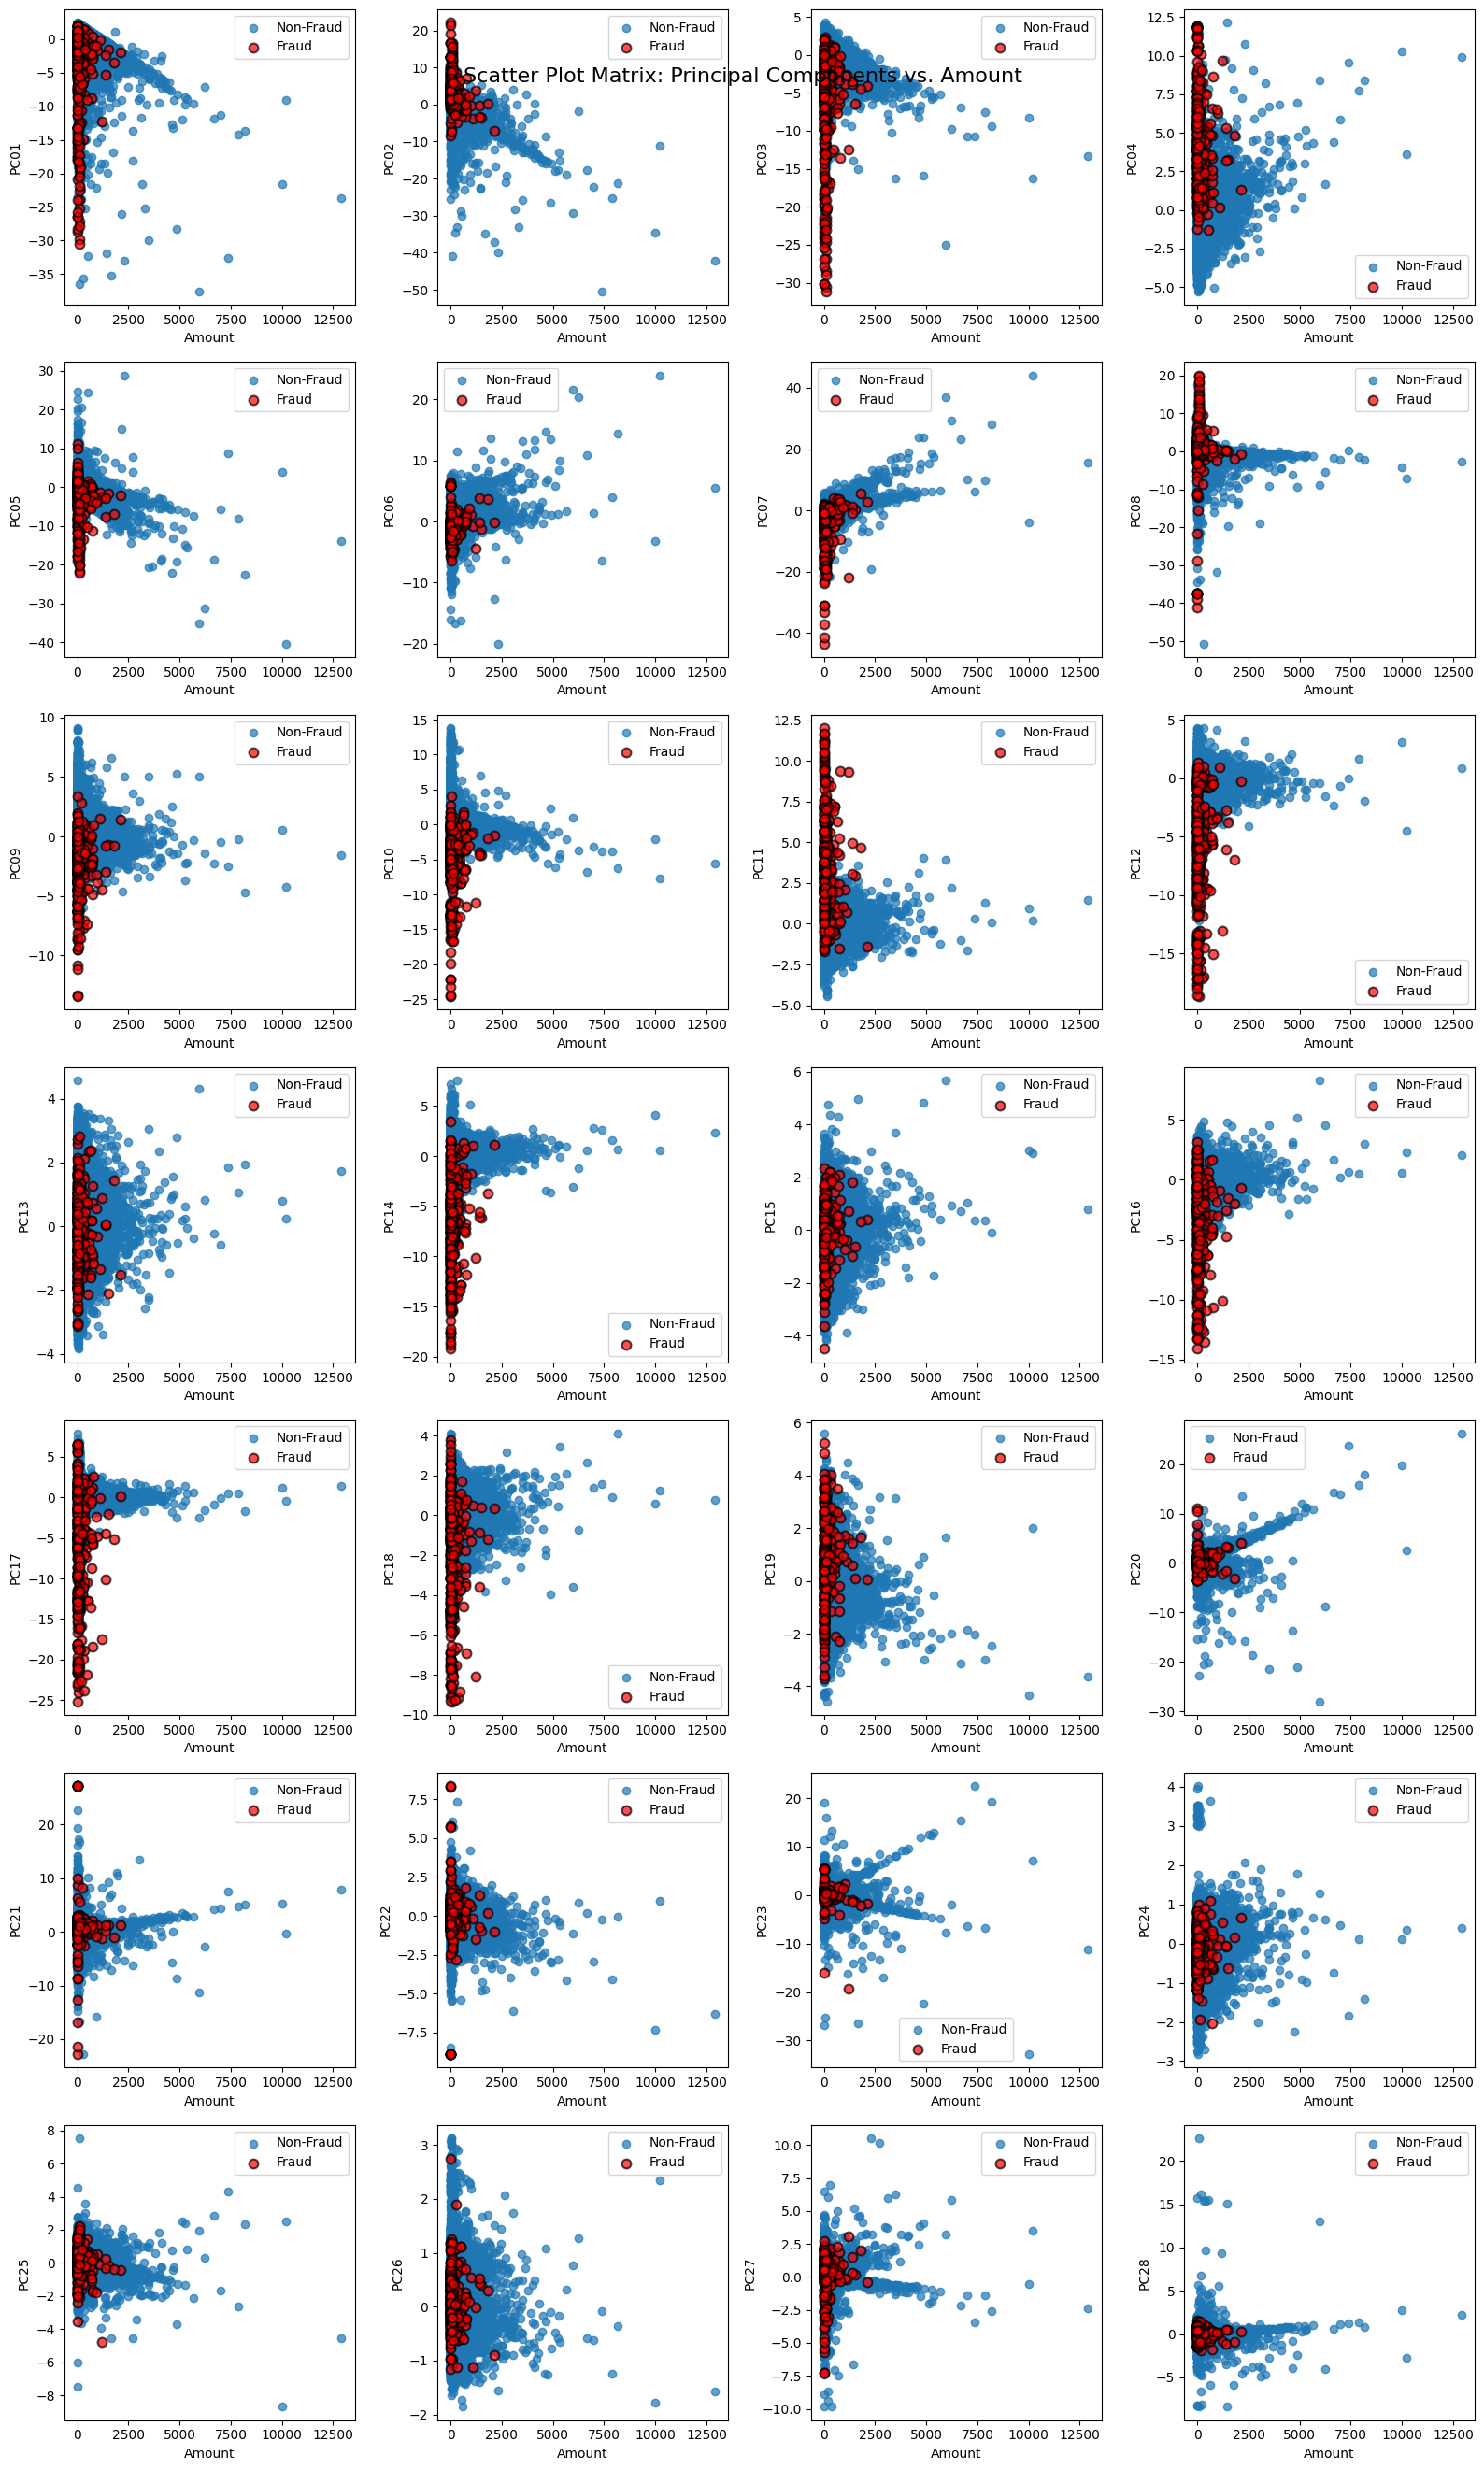

In [5]:
pc_columns = [col for col in fraud.columns if col.startswith('PC')]

fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(16, 28))
fig.suptitle('Scatter Plot Matrix: Principal Components vs. Amount', fontsize=16, y=0.92)

for i, pc in enumerate(pc_columns):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    non_fraud = fraud[fraud['Fraud'] == 0]
    fraud_cases = fraud[fraud['Fraud'] == 1]
    
    ax.scatter(non_fraud['Amount'], non_fraud[pc], alpha=0.7, label='Non-Fraud')
    ax.scatter(fraud_cases['Amount'], fraud_cases[pc], alpha=0.7, color='red', s=50, marker='o', edgecolors='black', linewidths=1.5, label='Fraud')
    
    ax.set_xlabel('Amount')
    ax.set_ylabel(pc)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Models

In [6]:
# process data for ML
svc = LinearSVC()
weights = [{0: 1, 1: x} for x in range(1, 21)]
weights.append("balanced")
param_grid = {
    'dual':['auto'],
    'class_weight':weights
}
scoring = { "recall": make_scorer(recall_score), "precision": make_scorer(precision_score),"f1": make_scorer(fbeta_score, beta=3)}

grid_search = GridSearchCV(svc,param_grid,cv=3,n_jobs = -1, scoring= scoring, refit = "f1")

In [7]:
# training ML model
grid_search.fit(X_train,y_train)
best_param = grid_search.best_params_
best_model = grid_search.best_estimator_
calibrated_model = CalibratedClassifierCV(best_model, method='isotonic', cv=3,ensemble=True)
calibrated_model.fit(X_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=LinearSVC(class_weight={0: 1, 1: 17},
                                           dual='auto'),
                       method='isotonic')

## Results

In [8]:
y_pred = calibrated_model.predict(X_test)
y_pred_proba = calibrated_model.predict_proba(X_test)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)

dump(calibrated_model,'credit-fraud.joblib')
precision, recall

(0.8939393939393939, 0.7468354430379747)

## Discussion

Our model after training reaches a precision of 0.894 and a recall of 0.747, using a weight of 1 on non-fraudulent data and 17 on fraudeulent data. Higher B is supposed to increase the weight of recall relative to precision, but our B value doesn't contribute much, meaning the overwhelming advantage in numbers of 1 over 0s in our data. A linear support vector classification model is chosen to handle the binary classification task of such a large number of samples quickly.

### Conclusion
We shall not use this model, since detecting fraudulent transaction is a really serious issue for everyone! If tens of thousands of transactions occur every minute, we need a super accurate model that provides a super high recall value, which represent the predicted frauds among occured true fraudulent transactions. By increasing recall rate, we decreases the amount of spam emails and calls forwarded to customers, and increases the chance of reducing further damages by closing accounts that had fraudulent transactions. 